In [2]:
import pandas as pd
import numpy as np

temp = pd.read_csv('Data/cv-valid-train.csv')
texts = temp['text']

words_list = np.hstack([x.split(' ') for x in texts])
words_list_df = pd.Series(words_list)
temp = words_list_df.value_counts()

common_words = temp[:1000]
for ind in range(1000,len(temp)):
    num_freq = common_words[-1]
    if temp[ind] == num_freq:
        common_words = pd.concat([common_words,temp[ind:ind+1]])
    else: break
print(common_words)

temp = None
texts = None
words_list = None


df = pd.read_csv('Data/Samples_1.csv')
df['words'] = df['words'].where(df['words'].isin(common_words.index),'[UNRECOGNIZED]')
print(len(df))
df.head()

the         141274
to           55997
and          41557
a            40516
of           36293
             ...  
carried        230
eastward       230
wasted         230
past           230
junior         230
Length: 1009, dtype: int64
47338


,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_2991,sample_2992,sample_2993,sample_2994,sample_2995,sample_2996,sample_2997,sample_2998,sample_2999,words
0,129,206,227,208,275,402,474,559,658,880,...,-6458,-4407,-2736,-1968,0,0,0,0,0,learn
1,-4786,-3695,-694,2025,3114,2906,1890,1563,2868,4372,...,6378,-4740,-14274,-14041,0,0,0,0,0,to
2,8766,2490,-2130,12988,8776,-5231,-2914,-3595,-12298,-7002,...,1671,1726,106,-1328,193,928,1603,1423,1183,[UNRECOGNIZED]
3,718,165,-1624,-1544,1007,620,1096,-1256,-1975,60,...,345,1353,1125,-5120,-5043,-3150,-4747,-5659,-5833,omens
4,320,-109,590,895,389,334,871,948,1581,1838,...,-20211,-20799,-21697,-18167,0,0,0,0,0,and


In [25]:
from pydub import AudioSegment

samps = np.array(X.iloc[3])
frame_rate = 18987
#note: frame_rate is educated guess, will vary based on number of syllables and length of original audio
audio_segment = AudioSegment(samps,frame_rate=frame_rate,
                             sample_width=2,channels=1)
audio_segment

In [47]:
from sklearn.preprocessing import LabelBinarizer
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint



X = df.drop('words',axis=1)
y_raw = df['words']

lb = LabelBinarizer()
y = lb.fit_transform(y_raw)
print(y.shape)


X_train,X_val,y_train,y_val = train_test_split(X,y)
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_val_scale = ss.transform(X_val)


y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights[0]= d_class_weights[0]/1000
print(len(d_class_weights))

if len(d_class_weights)<y.shape[1]:
    init_len = len(d_class_weights)
    diff = y.shape[1]-init_len
    for i in range(diff):
        ind = init_len + i
        d_class_weights[ind] = 0
print(len(d_class_weights))

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

1008
1009


In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

One large hidden layer
35503/35503 [==============================] - 18s 515us/step
----------
Training Loss: 7.88 
Training Accuracy: 0.496
11835/11835 [==============================] - 6s 510us/step
----------
Validation Loss: 11.9 
Validation Accuracy: 0.0107


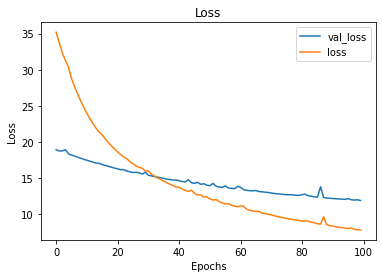

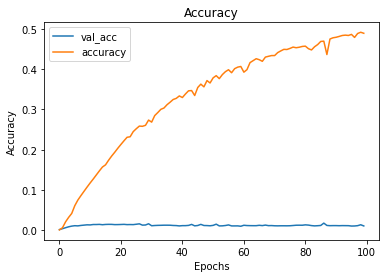

In [48]:
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

OHL_model = models.Sequential()
OHL_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.005),input_shape=(3000,)))
OHL_model.add(layers.Dense(1009,activation='softmax'))
OHL_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



OHL_results=OHL_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('One large hidden layer')
results_train = OHL_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = OHL_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(OHL_results)

RV = 0.5, dropout, 2 dropout layers
35503/35503 [==============================] - 18s 519us/step
----------
Training Loss: 10.6 
Training Accuracy: 0.0445
11835/11835 [==============================] - 6s 506us/step
----------
Validation Loss: 10.9 
Validation Accuracy: 0.0223


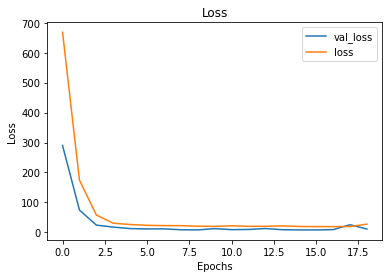

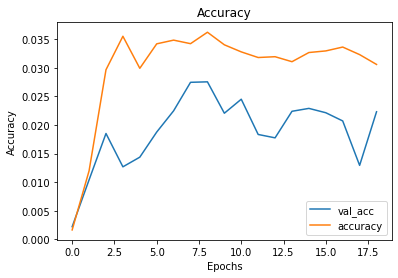

RV = 0.8
35503/35503 [==============================] - 19s 522us/step
----------
Training Loss: 7.77 
Training Accuracy: 0.0375
11835/11835 [==============================] - 6s 514us/step
----------
Validation Loss: 7.98 
Validation Accuracy: 0.024


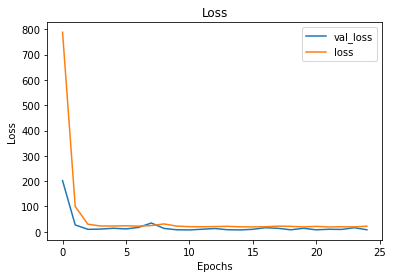

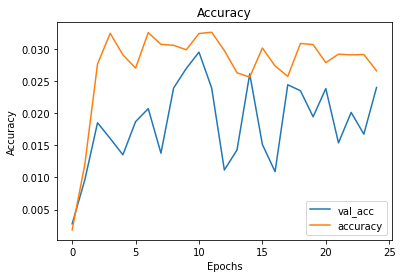

Smaller batch size
35503/35503 [==============================] - 20s 567us/step
----------
Training Loss: 9.24 
Training Accuracy: 0.0424
11835/11835 [==============================] - 7s 568us/step
----------
Validation Loss: 9.58 
Validation Accuracy: 0.0231


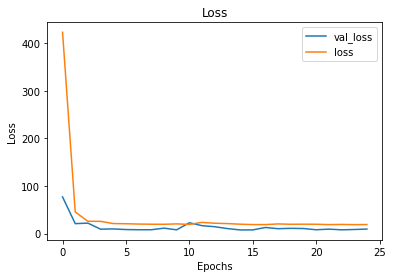

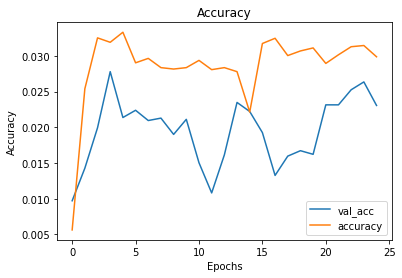

Larger batch size
35503/35503 [==============================] - 20s 551us/step
----------
Training Loss: 7.2 
Training Accuracy: 0.0514
11835/11835 [==============================] - 6s 547us/step
----------
Validation Loss: 7.57 
Validation Accuracy: 0.0237


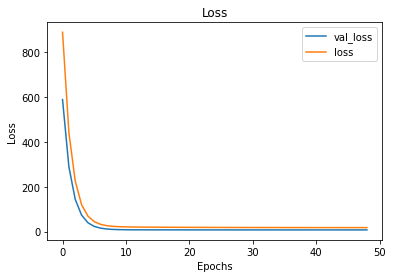

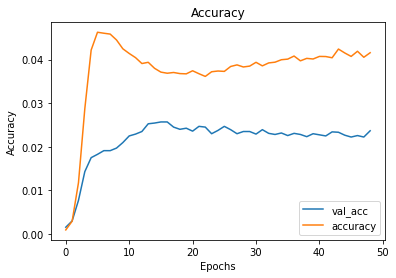

In [64]:
two_do = models.Sequential()
two_do.add(layers.Dropout(0.1,input_shape=(3000,)))
two_do.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.5)))
two_do.add(layers.Dropout(0.1))
two_do.add(layers.Dense(1009,activation='softmax'))
two_do.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



two_do_res=two_do.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('RV = 0.5, dropout, 2 dropout layers')
results_train = two_do.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = two_do.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(two_do_res)

rv_8_do = models.Sequential()
rv_8_do.add(layers.Dropout(0.1,input_shape=(3000,)))
rv_8_do.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.8)))
rv_8_do.add(layers.Dense(1009,activation='softmax'))
rv_8_do.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



rv_8_do_res=rv_8_do.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('RV = 0.8')
results_train = rv_8_do.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = rv_8_do.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(rv_8_do_res)


sm_batch = models.Sequential()
sm_batch.add(layers.Dropout(0.1,input_shape=(3000,)))
sm_batch.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.5)))
sm_batch.add(layers.Dense(1009,activation='softmax'))
sm_batch.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



sm_batch_res=sm_batch.fit(X_train_scale,y_train,epochs=100,batch_size=250,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Smaller batch size')
results_train = sm_batch.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = sm_batch.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(sm_batch_res)



L_batch = models.Sequential()
L_batch.add(layers.Dropout(0.1,input_shape=(3000,)))
L_batch.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.5)))
L_batch.add(layers.Dense(1009,activation='softmax'))
L_batch.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



L_batch_res=L_batch.fit(X_train_scale,y_train,epochs=100,batch_size=1000,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Larger batch size')
results_train = L_batch.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = L_batch.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(L_batch_res)


Larger batch size
35503/35503 [==============================] - 17s 480us/step
----------
Training Loss: 7.15 
Training Accuracy: 0.0506
11835/11835 [==============================] - 5s 458us/step
----------
Validation Loss: 7.52 
Validation Accuracy: 0.0228


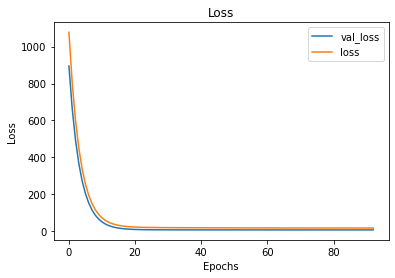

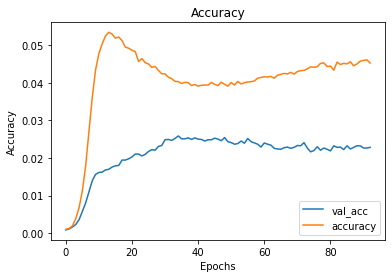

In [65]:
L_batch = models.Sequential()
L_batch.add(layers.Dropout(0.1,input_shape=(3000,)))
L_batch.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.5)))
L_batch.add(layers.Dense(1009,activation='softmax'))
L_batch.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



L_batch_res=L_batch.fit(X_train_scale,y_train,epochs=100,batch_size=2500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Larger batch size')
results_train = L_batch.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = L_batch.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(L_batch_res)

Dropout
35503/35503 [==============================] - 18s 510us/step
----------
Training Loss: 8.63 
Training Accuracy: 0.107
11835/11835 [==============================] - ETA:  - ETA:  - 6s 489us/step
----------
Validation Loss: 9.82 
Validation Accuracy: 0.017


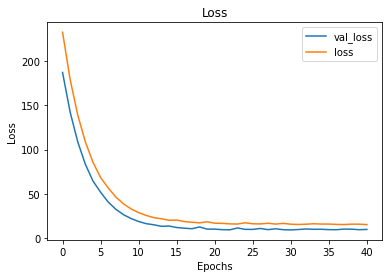

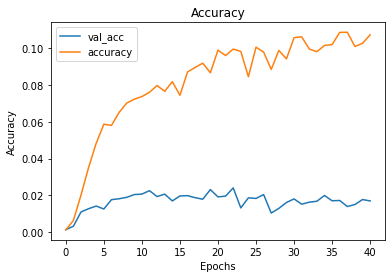

Reg value = 0.5
35503/35503 [==============================] - 19s 528us/step
----------
Training Loss: 8.15 
Training Accuracy: 0.0448
11835/11835 [==============================] - 6s 511us/step
----------
Validation Loss: 8.49 
Validation Accuracy: 0.0206


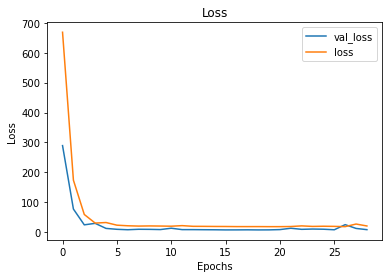

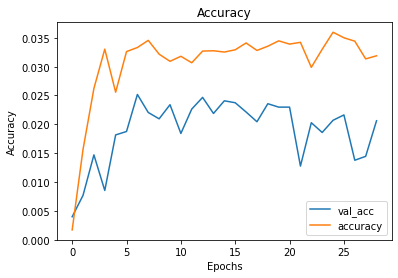

RV = 0.5, dropout
35503/35503 [==============================] - 18s 503us/step
----------
Training Loss: 7.58 
Training Accuracy: 0.0483
11835/11835 [==============================] - 6s 501us/step
----------
Validation Loss: 7.92 
Validation Accuracy: 0.0215


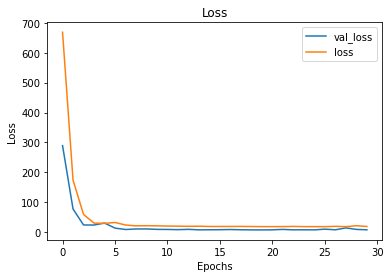

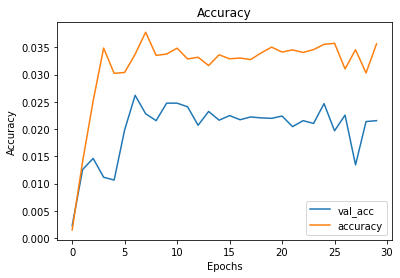

More Dropout
35503/35503 [==============================] - 18s 495us/step
----------
Training Loss: 11.4 
Training Accuracy: 0.101
11835/11835 [==============================] - 6s 482us/step
----------
Validation Loss: 12.6 
Validation Accuracy: 0.0145


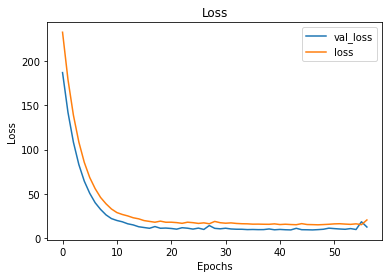

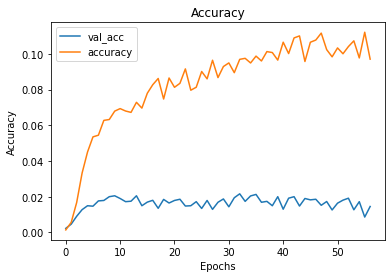

In [61]:
'''do_model = models.Sequential()
do_model.add(layers.Dropout(0.1,input_shape=(3000,)))
do_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
do_model.add(layers.Dense(1009,activation='softmax'))
do_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



do_results=do_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)'''

print('Dropout')
results_train = do_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = do_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(do_results)


'''rv_5 = models.Sequential()
rv_5.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.5),input_shape=(3000,)))
rv_5.add(layers.Dense(1009,activation='softmax'))
rv_5.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



rv_5_res=rv_5.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)'''

print('Reg value = 0.5')
results_train = rv_5.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = rv_5.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(rv_5_res)


rv_5_do = models.Sequential()
rv_5_do.add(layers.Dropout(0.1,input_shape=(3000,)))
rv_5_do.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.5)))
rv_5_do.add(layers.Dense(1009,activation='softmax'))
rv_5_do.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



rv_5_do_res=rv_5_do.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('RV = 0.5, dropout')
results_train = rv_5_do.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = rv_5_do.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(rv_5_do_res)


more_do = models.Sequential()
more_do.add(layers.Dropout(0.2,input_shape=(3000,)))
more_do.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1)))
more_do.add(layers.Dense(1009,activation='softmax'))
more_do.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



more_do_res=more_do.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('More Dropout')
results_train = more_do.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = more_do.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(more_do_res)

Greater regularization value
35503/35503 [==============================] - 17s 473us/step
----------
Training Loss: 7.64 
Training Accuracy: 0.403
11835/11835 [==============================] - 5s 465us/step
----------
Validation Loss: 11.4 
Validation Accuracy: 0.0136


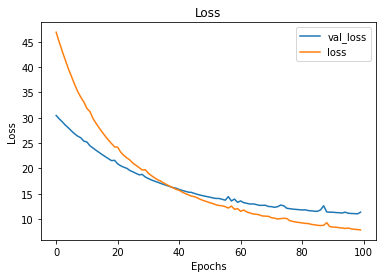

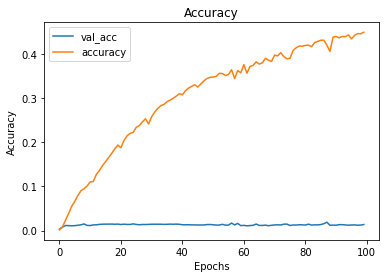

L1 Regularization
35503/35503 [==============================] - 17s 470us/step
----------
Training Loss: 12.3 
Training Accuracy: 0.0329
11835/11835 [==============================] - 5s 461us/step
----------
Validation Loss: 12.3 
Validation Accuracy: 0.0295


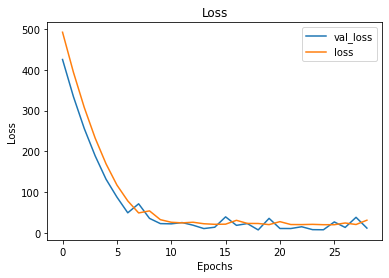

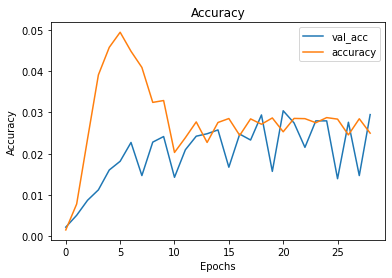

L1, greater value
35503/35503 [==============================] - 17s 471us/step
----------
Training Loss: 15.6 
Training Accuracy: 0.0304
11835/11835 [==============================] - 6s 469us/step
----------
Validation Loss: 15.6 
Validation Accuracy: 0.029


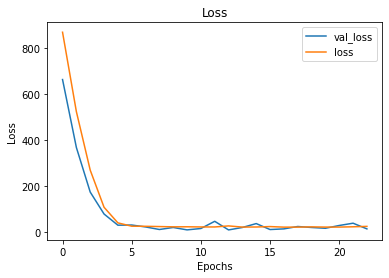

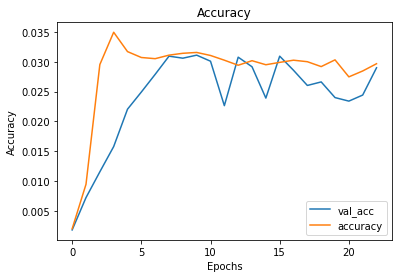

In [49]:
alpha_doubled = models.Sequential()
alpha_doubled.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.01),input_shape=(3000,)))
alpha_doubled.add(layers.Dense(1009,activation='softmax'))
alpha_doubled.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



ad_results=alpha_doubled.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Greater regularization value')
results_train = alpha_doubled.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = alpha_doubled.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(ad_results)


L1_model = models.Sequential()
L1_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l1(0.005),input_shape=(3000,)))
L1_model.add(layers.Dense(1009,activation='softmax'))
L1_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



L1_results=L1_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('L1 Regularization')
results_train = L1_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = L1_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(L1_results)

L1_ad_model = models.Sequential()
L1_ad_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l1(0.01),input_shape=(3000,)))
L1_ad_model.add(layers.Dense(1009,activation='softmax'))
L1_ad_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



L1_ad_results=L1_ad_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('L1, greater value')
results_train = L1_ad_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = L1_ad_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(L1_ad_results)

L2 value = 0.02
35503/35503 [==============================] - 18s 505us/step
----------
Training Loss: 7.32 
Training Accuracy: 0.348
11835/11835 [==============================] - 6s 492us/step
----------
Validation Loss: 10.5 
Validation Accuracy: 0.0149


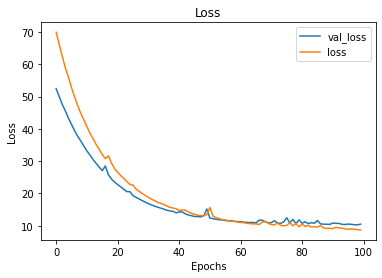

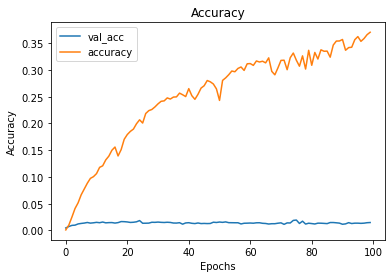

L2 value = 0.05
35503/35503 [==============================] - 19s 531us/step
----------
Training Loss: 8.01 
Training Accuracy: 0.204
11835/11835 [==============================] - 6s 524us/step
----------
Validation Loss: 9.94 
Validation Accuracy: 0.0171


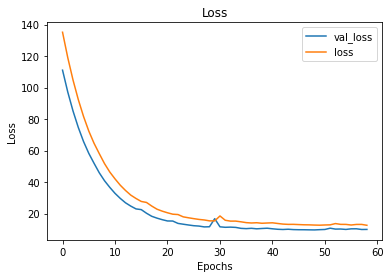

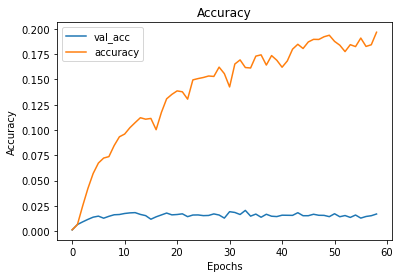

L2 value = 0.1
35503/35503 [==============================] - 18s 493us/step
----------
Training Loss: 8.41 
Training Accuracy: 0.119
11835/11835 [==============================] - 6s 482us/step
----------
Validation Loss: 9.64 
Validation Accuracy: 0.0215


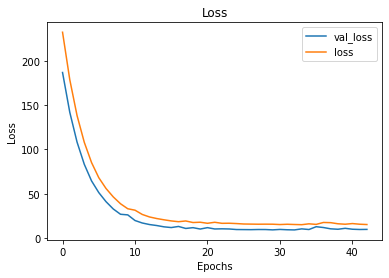

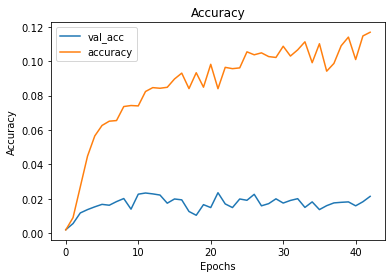

In [50]:
reg_02 = models.Sequential()
reg_02.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.02),input_shape=(3000,)))
reg_02.add(layers.Dense(1009,activation='softmax'))
reg_02.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



reg_02_results=reg_02.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('L2 value = 0.02')
results_train = reg_02.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = reg_02.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(reg_02_results)


reg_05 = models.Sequential()
reg_05.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.05),input_shape=(3000,)))
reg_05.add(layers.Dense(1009,activation='softmax'))
reg_05.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



reg_05_results=reg_05.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('L2 value = 0.05')
results_train = reg_05.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = reg_05.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(reg_05_results)


reg_1 = models.Sequential()
reg_1.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.1),input_shape=(3000,)))
reg_1.add(layers.Dense(1009,activation='softmax'))
reg_1.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



reg_1_results=reg_1.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('L2 value = 0.1')
results_train = reg_1.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = reg_1.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(reg_1_results)

### ---------------------------------------------------

Activation = tanh
45000/45000 [==============================] - 18s 400us/step
----------
Training Loss: 6.96 
Training Accuracy: 0.232
15000/15000 [==============================] - 5s 350us/step
----------
Validation Loss: 9.57 
Validation Accuracy: 0.00173


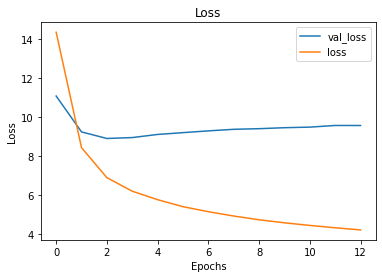

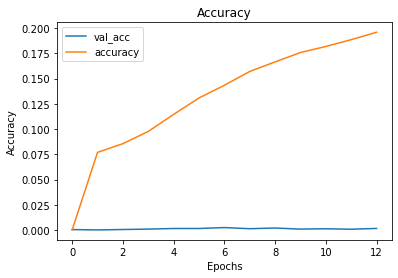

In [11]:
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

tanh_model = models.Sequential()
tanh_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005),input_shape=(3000,)))
tanh_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
tanh_model.add(layers.Dense(1008,activation='softmax'))
tanh_model.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['accuracy'])



tanh_results=tanh_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Activation = tanh')
results_train = tanh_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = tanh_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(tanh_results)

Optimizer = sgd
45000/45000 [==============================] - 17s 372us/step
----------
Training Loss: 9.29 
Training Accuracy: 0.142
15000/15000 [==============================] - 5s 365us/step
----------
Validation Loss: 10.2 
Validation Accuracy: 0.000133


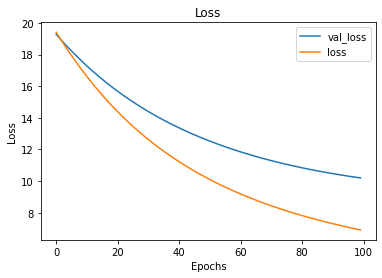

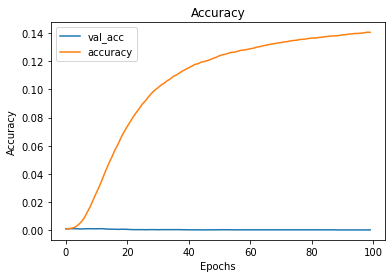

Optimizer = Adagrad
45000/45000 [==============================] - 17s 369us/step
----------
Training Loss: 6.55 
Training Accuracy: 0.246
15000/15000 [==============================] - 5s 364us/step
----------
Validation Loss: 9.23 
Validation Accuracy: 0.0014


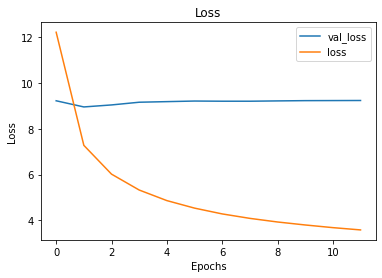

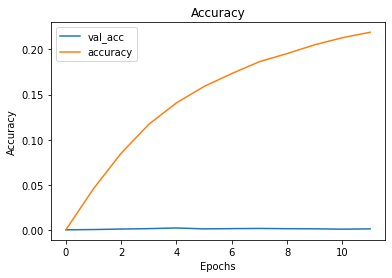

Optimizer = RMSprop
45000/45000 [==============================] - 16s 361us/step
----------
Training Loss: 7.45 
Training Accuracy: 0.226
15000/15000 [==============================] - 5s 358us/step
----------
Validation Loss: 9.98 
Validation Accuracy: 0.00313


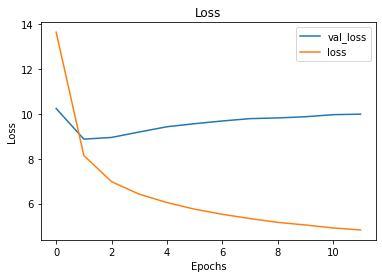

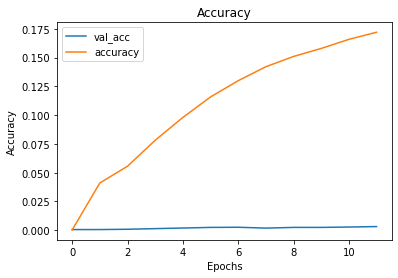

ValueError: Unknown optimizer: Ftrl

In [12]:
sgd_model = models.Sequential()
sgd_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005),input_shape=(3000,)))
sgd_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
sgd_model.add(layers.Dense(1008,activation='softmax'))
sgd_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



sgd_results=sgd_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Optimizer = sgd')
results_train = sgd_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = sgd_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(sgd_results)

adagrad_model = models.Sequential()
adagrad_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005),input_shape=(3000,)))
adagrad_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
adagrad_model.add(layers.Dense(1008,activation='softmax'))
adagrad_model.compile(loss='categorical_crossentropy',optimizer='Adagrad',metrics=['accuracy'])



adagrad_results=adagrad_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Optimizer = Adagrad')
results_train = adagrad_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = adagrad_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(adagrad_results)

rmsprop_model = models.Sequential()
rmsprop_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005),input_shape=(3000,)))
rmsprop_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
rmsprop_model.add(layers.Dense(1008,activation='softmax'))
rmsprop_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])



rmsprop_results=rmsprop_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Optimizer = RMSprop')
results_train = rmsprop_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = rmsprop_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(rmsprop_results)

ftrl_model = models.Sequential()
ftrl_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005),input_shape=(3000,)))
ftrl_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
ftrl_model.add(layers.Dense(1008,activation='softmax'))
ftrl_model.compile(loss='categorical_crossentropy',optimizer='Ftrl',metrics=['accuracy'])



ftrl_results=ftrl_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Optimizer = Ftrl')
results_train = ftrl_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = ftrl_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(ftrl_results)

With Dropout
45000/45000 [==============================] - 17s 372us/step
----------
Training Loss: 7.69 
Training Accuracy: 0.15
15000/15000 [==============================] - 5s 366us/step
----------
Validation Loss: 8.85 
Validation Accuracy: 0.000467


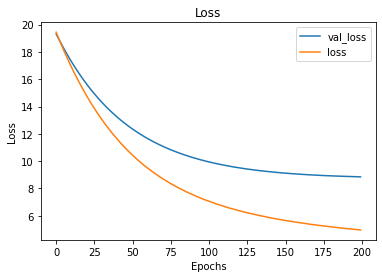

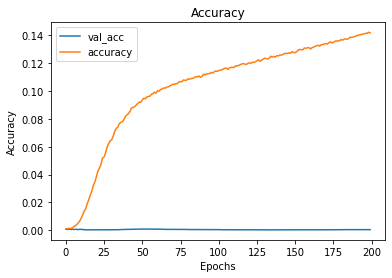

One large hidden layer
45000/45000 [==============================] - 25s 566us/step
----------
Training Loss: 6.08 
Training Accuracy: 0.302
15000/15000 [==============================] - 8s 560us/step
----------
Validation Loss: 8.5 
Validation Accuracy: 0.000667


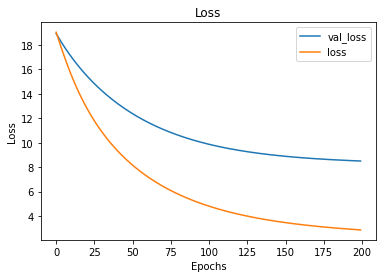

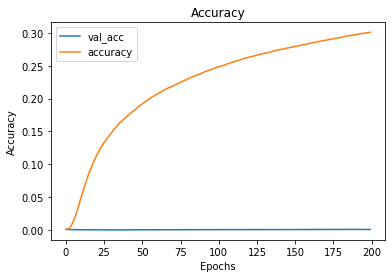

One large hidden layer with dropout
45000/45000 [==============================] - 25s 548us/step
----------
Training Loss: 6.1 
Training Accuracy: 0.289
15000/15000 [==============================] - 8s 540us/step
----------
Validation Loss: 8.46 
Validation Accuracy: 0.000667


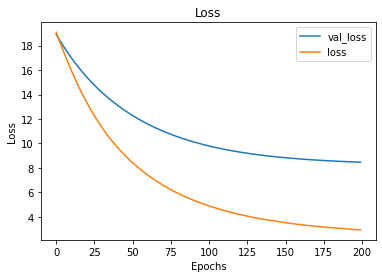

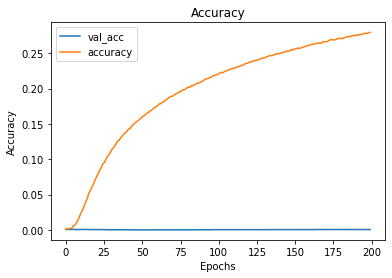

In [14]:
do_model = models.Sequential()
do_model.add(layers.Dropout(0.3,input_shape=(3000,)))
do_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
do_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
do_model.add(layers.Dense(1008,activation='softmax'))
do_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



do_results=do_model.fit(X_train_scale,y_train,epochs=200,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('With Dropout')
results_train = do_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = do_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(do_results)

OHL_model = models.Sequential()
OHL_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.005),input_shape=(3000,)))
OHL_model.add(layers.Dense(1008,activation='softmax'))
OHL_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



OHL_results=OHL_model.fit(X_train_scale,y_train,epochs=200,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('One large hidden layer')
results_train = OHL_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = OHL_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(OHL_results)

OHL_do_model = models.Sequential()
OHL_do_model.add(layers.Dropout(0.3,input_shape=(3000,)))
OHL_do_model.add(layers.Dense(2000,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
OHL_do_model.add(layers.Dense(1008,activation='softmax'))
OHL_do_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])



OHL_do_results=OHL_do_model.fit(X_train_scale,y_train,epochs=200,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('One large hidden layer with dropout')
results_train = OHL_do_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = OHL_do_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(OHL_do_results)

## Previous attempts: using only one data set, included "unrecognized" category

Train on 35503 samples, validate on 11835 samples
Epoch 1/25
35503/35503 [==============================] - 28s 797us/step - loss: 6302858.2306 - accuracy: 0.0346 - val_loss: 10491767.4930 - val_accuracy: 0.0199
Epoch 2/25
35503/35503 [==============================] - 22s 624us/step - loss: 5352470.8947 - accuracy: 0.1705 - val_loss: 10406856.4187 - val_accuracy: 0.0337
Epoch 3/25
35503/35503 [==============================] - 24s 671us/step - loss: 5073037.5064 - accuracy: 0.2383 - val_loss: 11427642.3599 - val_accuracy: 0.0237
Epoch 4/25
35503/35503 [==============================] - 22s 631us/step - loss: 4969668.9235 - accuracy: 0.2702 - val_loss: 11205105.0135 - val_accuracy: 0.0246
Epoch 5/25
35503/35503 [==============================] - 22s 633us/step - loss: 4752838.3285 - accuracy: 0.3024 - val_loss: 13039877.6675 - val_accuracy: 0.0254
Epoch 6/25
35503/35503 [==============================] - 23s 648us/step - loss: 4663543.4857 - accuracy: 0.3247 - val_loss: 11470219.5277 -

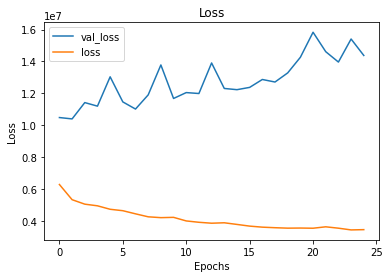

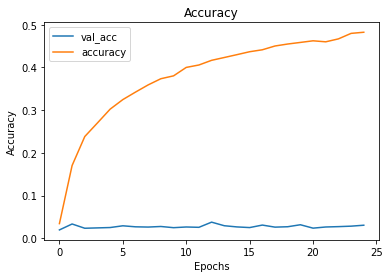

In [32]:
baseline = models.Sequential()
baseline.add(layers.Dense(1009,activation='softmax',input_shape=(3000,)))
baseline.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

results=baseline.fit(X_train,y_train,epochs=25,batch_size=50,validation_data=(X_val,y_val))
visualize_training_results(results)

Severe overfitting, but also, this model has zero hidden layers.
Other things to keep in mind: normalize, and weights

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

X_train,X_val,y_train,y_val = train_test_split(X,y)
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_val_scale = ss.transform(X_val)


y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

D:\Alex\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[   0    1    2 ... 1006 1007 1008], y=[485 309 202 ... 852 920 386] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.007324380327262795,
 1: 0.044371151440315844,
 2: 5.026617584595781,
 3: 1.5993783223713849,
 4: 0.17681569393050486,
 5: 3.5186323092170464,
 6: 5.026617584595781,
 7: 17.593161546085234,
 8: 35.18632309217047,
 9: 3.909591454685607,
 10: 3.909591454685607,
 11: 2.5133087922978903,
 12: 3.1987566447427698,
 13: 0.8796580773042616,
 14: 3.5186323092170464,
 15: 1.5298401344421941,
 16: 2.1991451932606543,
 17: 2.9321935910142054,
 18: 0.32579928789046725,
 19: 5.864387182028411,
 20: 5.026617584595781,
 21: 0.2792565324775434,
 22: 2.1991451932606543,
 23: 3.909591454685607,
 24: 5.026617584595781,
 25: 0.9259558708465913,
 26: 2.5133087922978903,
 27: 1.0053235169191561,
 28: 2.5133087922978903,
 29: 1.5298401344421941,
 30: 0.3449639518840242,
 31: 0.04312049398550302,
 32: 3.5186323092170464,
 33: 1.0053235169191561,
 34: 5.864387182028411,
 35: 0.8377695974326301,
 36: 4.3982903865213085,
 37: 0.9022134126197555,
 38: 11.728774364056822,
 39: 3.5186323092170464,
 40: 1.034891

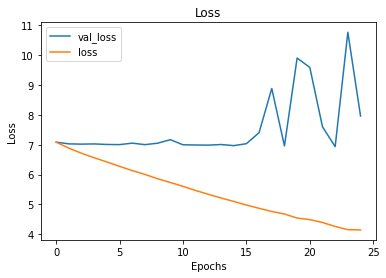

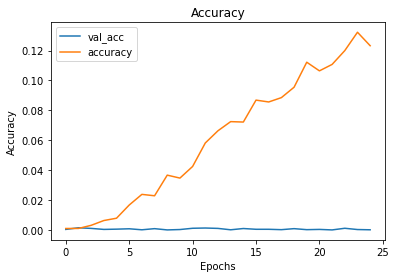

In [39]:
model = models.Sequential()
model.add(layers.Dense(2000,activation='relu',input_shape=(3000,)))
model.add(layers.Dense(1500,activation='relu'))
model.add(layers.Dense(1009,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

results=model.fit(X_train_scale,y_train,epochs=25,batch_size=500,validation_data=(X_val_scale,y_val),
                  class_weight = d_class_weights,verbose=False)
visualize_training_results(results)

35503/35503 [==============================] - 6s 162us/step
----------
Training Loss: 7.63 
Training Accuracy: 0.000479
11835/11835 [==============================] - 2s 153us/step
----------
Validation Loss: 7.63 
Validation Accuracy: 0.000338


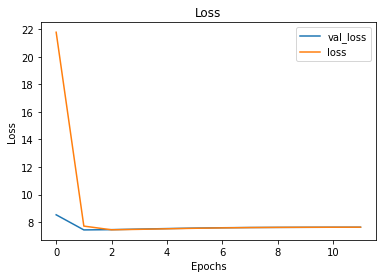

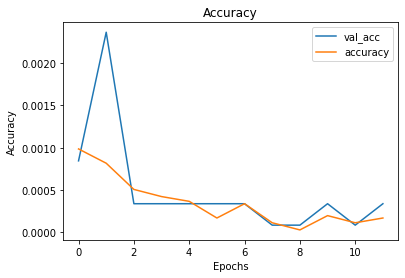

35503/35503 [==============================] - 7s 184us/step
----------
Training Loss: 7.0 
Training Accuracy: 0.12
11835/11835 [==============================] - 2s 177us/step
----------
Validation Loss: 8.11 
Validation Accuracy: 0.000253


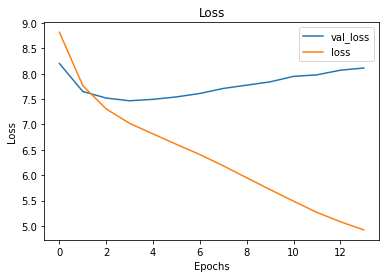

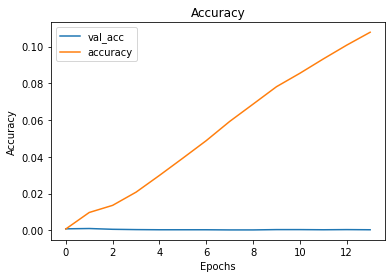

In [40]:
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint


L1_model = models.Sequential()
L1_model.add(layers.Dense(200,activation='relu',kernel_regularizer=regularizers.l1(0.005),input_shape=(3000,)))
L1_model.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
L1_model.add(layers.Dense(1009,activation='softmax'))
L1_model.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['accuracy'])

early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]


L1_results=L1_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

results_train = L1_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = L1_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(L1_results)


L2_model = models.Sequential()
L2_model.add(layers.Dense(200,activation='relu',kernel_regularizer=regularizers.l2(0.005),input_shape=(3000,)))
L2_model.add(layers.Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
L2_model.add(layers.Dense(1009,activation='softmax'))
L2_model.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['accuracy'])



L2_results=L2_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

results_train = L2_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = L2_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(L2_results)

Activation = tanh
35503/35503 [==============================] - 13s 362us/step
----------
Training Loss: 5.46 
Training Accuracy: 0.357
11835/11835 [==============================] - 4s 359us/step
----------
Validation Loss: 9.31 
Validation Accuracy: 0.00372


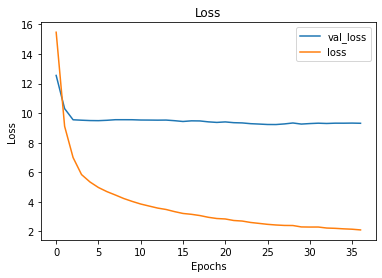

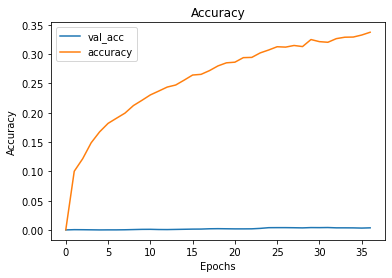

Activation = tanh, fewer nodes
35503/35503 [==============================] - 5s 152us/step
----------
Training Loss: 7.06 
Training Accuracy: 0.107
11835/11835 [==============================] - 2s 145us/step
----------
Validation Loss: 7.68 
Validation Accuracy: 0.000169


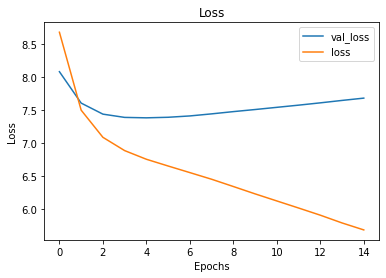

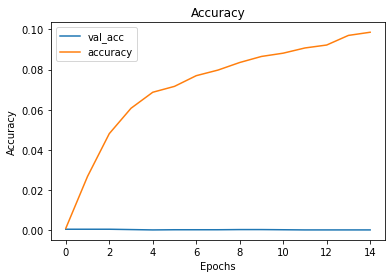

Activation = tanh, fewer nodes, more hidden layers
35503/35503 [==============================] - 6s 180us/step
----------
Training Loss: 7.38 
Training Accuracy: 0.0246
11835/11835 [==============================] - 2s 170us/step
----------
Validation Loss: 7.82 
Validation Accuracy: 0.000338


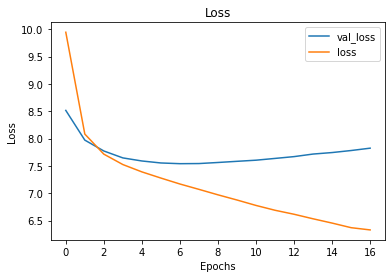

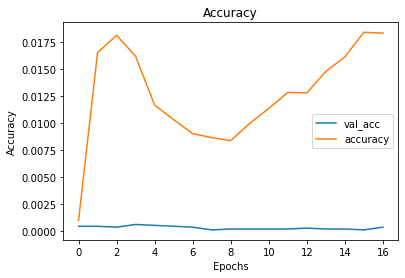

In [43]:
'''tanh_model = models.Sequential()
tanh_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005),input_shape=(3000,)))
tanh_model.add(layers.Dense(1000,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
tanh_model.add(layers.Dense(1009,activation='softmax'))
tanh_model.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['accuracy'])



tanh_results=tanh_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)'''

print('Activation = tanh')
results_train = tanh_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = tanh_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(tanh_results)

tanh_model_2 = models.Sequential()
tanh_model_2.add(layers.Dense(200,activation='tanh',kernel_regularizer=regularizers.l2(0.005),input_shape=(3000,)))
tanh_model_2.add(layers.Dense(100,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
tanh_model_2.add(layers.Dense(1009,activation='softmax'))
tanh_model_2.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['accuracy'])



tanh_results_2=tanh_model_2.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Activation = tanh, fewer nodes')
results_train = tanh_model_2.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = tanh_model_2.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(tanh_results_2)

tanh_model_3 = models.Sequential()
tanh_model_3.add(layers.Dense(300,activation='tanh',kernel_regularizer=regularizers.l2(0.005),input_shape=(3000,)))
tanh_model_3.add(layers.Dense(200,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
tanh_model_3.add(layers.Dense(100,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
tanh_model_3.add(layers.Dense(100,activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
tanh_model_3.add(layers.Dense(1009,activation='softmax'))
tanh_model_3.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['accuracy'])



tanh_results_3=tanh_model_3.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('Activation = tanh, fewer nodes, more hidden layers')
results_train = tanh_model_3.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = tanh_model_3.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(tanh_results_3)

With Dropout Layers
35503/35503 [==============================] - 18s 515us/step
----------
Training Loss: 7.17 
Training Accuracy: 0.183
11835/11835 [==============================] - 6s 506us/step
----------
Validation Loss: 8.65 
Validation Accuracy: 0.000591


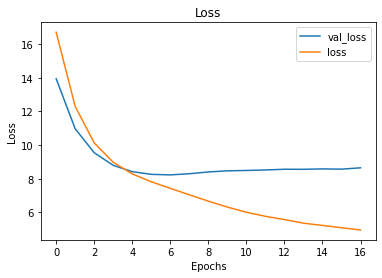

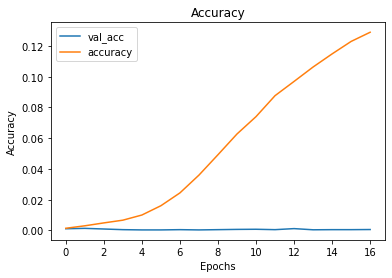

In [42]:
do_model = models.Sequential()
do_model.add(layers.Dropout(0.3,input_shape=(3000,)))
do_model.add(layers.Dense(1000,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
do_model.add(layers.Dropout(0.3))
do_model.add(layers.Dense(1000,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
do_model.add(layers.Dropout(0.3))
do_model.add(layers.Dense(1009,activation='softmax'))
do_model.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['accuracy'])



do_results=do_model.fit(X_train_scale,y_train,epochs=100,batch_size=500,validation_data=(X_val_scale,y_val),
                       callbacks=early_stopping,class_weight = d_class_weights,verbose=False)

print('With Dropout Layers')
results_train = do_model.evaluate(X_train_scale,y_train)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
results_val = do_model.evaluate(X_val_scale,y_val)
print('----------')
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

visualize_training_results(do_results)